### Sale Price versus Area Price

<div class='alert alert-warning'>
   &emsp; The ground living area has obvisouly a important impact on the sale price of a good. But one knows that it isn't enough enough to the simple estimation. One of the other most important criteria when etimating a good is its neighborhood. A downtown house will cost most certainly more than an equal size good in the suburbs due to the proximity of shops, cultural centers etc. So let's study how the neighborhood influences the Sale Price. Studying directly the raw neighborhood influence would not be wise. Indeed, city centers goods are more likely to be small goods than suburbs goods which will introduce a bias, we may think city centers good are not that expensive. To be more complete but not completly as we remove the influence of only one external factor: the ground living area , let's see the price of a square feet for each neighborhood.<br><br>
   &emsp; First let's retrieve the neighborhoods and locate them, calculate the average price of a square feet per neighborhood and view the result on a map to more expressive. <br><br>
   &emsp; Note:for obvious privacy reasons, the neighborhoods given are not precise and therefore our results will as well be inacurate but thanks to the google geocoder let's see if a relationship exsists between the saling price and the neighborhood.
</div>

In [165]:
#Retrieve all neighborhoods values in the text description
#Note : Previous study proves that no house has a neighborhood unspecified in the description file

dicStreetName = {} # Abbreviation : Street name/ included in the description file
dicStreetLoc = {} # Abbreviation : location returned by geocoder if any
for index in range(92,117):
    line = txtDescripData[index]
    line = line.strip()
    line = line.split('\t') #example of  line: Blmngtn \t Bloomington Heights
    dicStreetName[line[0]]= line[1][:-1]
    dicStreetLoc[line[0]] = geocoder.google(line[1][:-1]+', Ames') #Tries to geo locate the neighborhood with its full name

In [164]:
def calcAreasPrices(pdDF):
    """
    Returns dictionnaire = {"Neigborhood":areaPrice}
    
    """
    dicStreetPriceAreas={} #Initialisation
    
    def calcAreaPrice(row):
        """Add the price of a house to the neighboorhood total price and its living ground area """
        neighborhood = row.Neighborhood #Neighborhood of specific house
        try:
            dicStreetPriceAreas[neighborhood] #see if already defined not defined if firs occurence of neighborhood
        except KeyError: #catch only the case where neighborhood not initialised
            dicStreetPriceAreas[neighborhood]=[0,0,0] #initialisation [total_price,total_GrLivArea,Ratio]
        dicStreetPriceAreas[neighborhood][0]+=row.SalePrice
        dicStreetPriceAreas[neighborhood][1]+=row.GrLivArea
        
    none = pdDF.apply(calcAreaPrice,axis=1) #fill the dictionnary
    
    #All houses has been processed 
    for place in dicStreetPriceAreas:
        areaPrice = dicStreetPriceAreas[place][0]/dicStreetPriceAreas[place][1]
        dicStreetPriceAreas[place] = areaPrice #Keep only ratio price perGrLivArea
        
    return dicStreetPriceAreas
    
dicStreetPriceAreas = calcAreasPrices(pdAllData_Categ)
print('{"Neigborhood":areaPrice} : \n' ,dicStreetPriceAreas)

{"Neigborhood":areaPrice} : 
 {'CollgCr': 134.20907321268913, 'Veenker': 157.93215518992486, 'Crawfor': 117.79526406429392, 'NoRidge': 134.5778825865707, 'Mitchel': 120.4345101775343, 'Somerst': 141.3526981644201, 'NWAmes': 109.34922142439676, 'OldTown': 88.6970170743768, 'BrkSide': 104.35968445787177, 'Sawyer': 114.3139789297955, 'NridgHt': 164.28212597768118, 'NAmes': 113.10453186324358, 'SawyerW': 115.56211490221865, 'IDOTRR': 88.03711634546752, 'MeadowV': 91.63993206265333, 'Edwards': 96.6801143049252, 'Timber': 137.50264580369844, 'Gilbert': 116.73792501227965, 'StoneBr': 164.9875536676715, 'ClearCr': 118.21955592942687, 'NPkVill': 109.51351351351352, 'Blmngtn': 136.29760445157032, 'BrDale': 93.36761308592294, 'SWISU': 79.96221330114258, 'Blueste': 98.74326750448833}


In [178]:
def locateNeighborhood(dicStreetPriceAreas,colorHist):
    """
    For each neighborhood treis to geo locate it to build markers
    
    Returns the list of markers that embed the location of the neighborhoud, its color etc
    """
    markersList = []
    areaPrices = calcAreasPrices(pdAllData_Categ).values()

    for place in dicStreetPriceAreas:
        coordGeo = dicStreetLoc[place] #Latitude and Logitude of the neighbordhood
        areaPrice = dicStreetPriceAreas[place]
        #Compute the color
        index = [i for i,x in enumerate(colorHist[1]) if x<=areaPrice][-1]
        colorfloat = hist[0][max(0,index-1)] #Use the cumulative hist to get the color
        markerColor = clr.rgb2hex(cmapRdYlGn(1-colorfloat))#green to red
        
        #Setup the marker
        marker = CircleMarker(location=(coordGeo.lat, coordGeo.lng), radius=10, color=markerColor, fill_color=markerColor)
        if marker != None: markersList.append(marker)
    return markersList

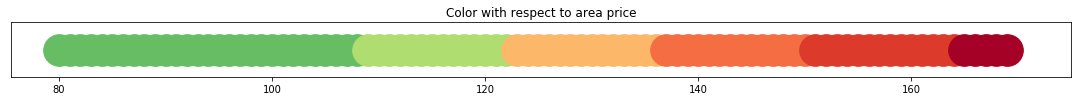

Area Price around Ames


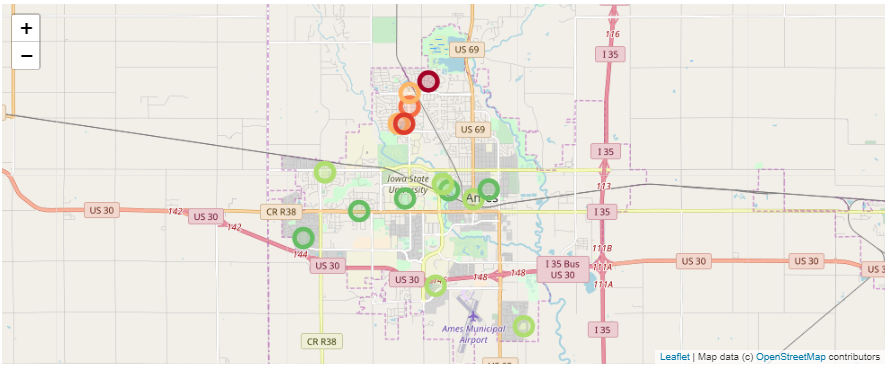

In [196]:
#Calculate cumulative hist to better color result
hist = plt.hist(areaPrices, cumulative=True, normed=True, bins='auto')
plt.clf()
plt.close()
markersList = locateNeighborhood(dicStreetPriceAreas,hist)

#PLot color bar
fig,ax = fig, ax = plt.subplots(figsize=(19,1))
plt.title("Color with respect to area price")
minPriceArea,maxPriceArea = 80,170
for areaPrice in np.arange(minPriceArea,maxPriceArea,1):
    #compute color for area price thanks to the cumulative histogramm
    index = [i for i,x in enumerate(hist[1]) if x<=areaPrice][-1]
    colorfloat = hist[0][max(0,index-1)] #Use the cumulative hist to get the color
    plt.scatter(areaPrice,0,c = cmapRdYlGn(1-colorfloat),s=1000)
plt.setp( ax.get_yticklabels(), visible=False)
ax.yaxis.set_ticks_position('none') 
plt.show()

#Plot the Map

g = geocoder.google('Ames') #Initialise the geocoder
m = Map(center=[g.lat, g.lng], zoom=12) #Initialise the map
group = LayerGroup(layers=markersList) #Convert to printable markers
m.add_layer(group)
print("Area Price around Ames")
m #Show the map not present when dowloaded as HTML
Image(filename='map.png') # a print screen of the map


<div class='alert alert-warning'>
&emsp; The results seem to indicate a clear distinction between boroughs. Indeed, the north west borough seem to be a lot more expensive as the others. The neighborhoods near the airport on the other hand, seem to be among the cheapest maybe because of noise polution due to the air traffic. 
<br>&emsp; City center seem to have median prices as well as west Ames.
<br><br>&emsp; In conclusion, this feature seem to give good information about a good. Knowing the neighborhood, one cann start to guess the price but without the GrLiveArea, it lacks information.
</div>

In [1]:
import os
import sys
import re
import random
import math
import scipy
import numpy as np
import pandas as pd
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.cm as cm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import IsolationForest
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline


from mpl_toolkits.mplot3d import Axes3D
cmapRdYlGn = cm.get_cmap('RdYlGn')
cmap = cm.coolwarm


challenge_data_folder = "./challenge_data"

from minisom import MiniSom
import seaborn as sns
from IPython.display import Image

ModuleNotFoundError: No module named 'minisom'

## Cleaning

In [119]:
pdAllData_Categ = pd.read_csv(challenge_data_folder+"/train.csv",keep_default_na=False) #Load training data NA filter FALSE to keep Not available data
pdTestData_Categ = pd.read_csv(challenge_data_folder+"/test.csv",keep_default_na=False)
#Categ indicates that no label encoding has been performed, the categorical features are untouched
columnTypesDict = pdAllData_Categ.dtypes.to_dict() #Infer part of the data schema
columnNames = list(columnTypesDict.keys()) #List of all features name


<div class='alert alert-warning'>
&emsp;At a first, the only information we have on the data set resides in the description file therefore we tried to match the data and the description file to make sure the data is clean and clear. One must first match features names and then specified values in the description file and in the dataset<br>
<br>&emsp; To do so, we firstly extract the lines that corresponds to each feature in the description file. Thanks to that, we extract the values specified in the description file for the features. Finnaly we chanck if any values in the actual data is not specified in the description or of an invalid type.
</div>

<div class='alert alert-warning'>
<h4>Parsing functions to extract all informations from the description file
</div>

In [536]:
def retrieveFeatureLineNumber(NoHeaderTxtDescripData):
    columnIndex=[]

    #Parse the description file to retrieve all the lines that corresponds to features    
    for feature in columnNames:
        if feature == 'Id': continue #No need to check
        for index,line in enumerate(NoHeaderTxtDescripData):
            if feature in line: #Match features name and stated name in the description
                if(line.split(feature)[0]=='' and line.split(feature)[1][0]==':' ): #Make sure exactly this feature in this line 
                    columnIndex.append((feature,index)) #We retrieved the line where the feature is described
                pass
    return columnIndex

def retrieveSpecificVal(NoHeaderTxtDescripData,columnIndex):
    NoSpecificValfeatures = []
    SpecificVal = {} #Will contain as keys column names and values the specified values in the description file
    
    #Scan the cocument to retrieve specfic values for each featurers
    for index,featureLine in enumerate(columnIndex):

        startLine= featureLine[1]+2  #RTF file format 
        if index == len(columnIndex)-1: endLine = len(NoHeaderTxtDescripData)-1
        else: endLine = columnIndex[index+1][1]-1
        values = []
        if endLine <= startLine: #No specified value in the description file
            NoSpecificValfeatures.append(featureLine[0])
            continue
        for i in range(startLine,endLine):
            line = NoHeaderTxtDescripData[i] 
            values.append(line.split('\t')[0].strip())
        SpecificVal[featureLine[0]]=values #All values specified are retrieved and kept in this dictionary
    return SpecificVal,NoSpecificValfeatures

<div class='alert alert-warning'>
<h4>Scan data for invalid entries for a future cleaning
</div>

In [559]:
def detectBadSpecificVal(pdAllData_Categ,SpecificVal):
    dicBadValues = []
    """ Scan categorical features for unspecified or bad values 
    return dicBadValues = [['feature', {BadValue: Nb of occurence}]
    """
    for factor in SpecificVal:
    #For a factor search for any value not specified in the description file 
    
        typeCol = columnTypesDict[factor]
        if typeCol == 'int64': valSpec = [int(i) for i in SpecificVal[factor]] #check if every column vales are of the good type
        else: valSpec = SpecificVal[factor]
        pdInter = pdAllData_Categ.apply(lambda x: x[factor] not in valSpec,axis=1) #scan the data and check if in the specified values
        potentialBadValues = pdAllData_Categ[pdInter]
        
        nbBadVal = len(potentialBadValues) #Number of bad values detected 

        if nbBadVal>0:
            badValues = [factor] #There are bad values for the feature factor 
            badValues.append(potentialBadValues.groupby(factor)[factor].count().to_dict()) #Compute the number of occurence of the bad value
            dicBadValues.append(badValues)
    return dicBadValues

def detectBadNotSpecificVal(pdAllData_Categ,NoSpecificValfeatures):
    #Retrieve Bad values for the columns with not specified values such as year of construction of 
    """ Scan numerical features for invalid entries 
    return dicBadValues = [['feature', {BadValue: Nb of occurence}]
    """
    dicBadValuesNotSpecific=[]
    for feature in NoSpecificValfeatures:
        dtypeColumn = columnTypesDict[feature]
        if dtypeColumn=='float64': typeFun = float #infered type -> check if any values do not convert to this type
        elif dtypeColumn=='int64': typeFun = int
        else: typeFun=lambda x: True
        pdInter = pdAllData_Categ[pdAllData_Categ.apply(lambda x: (x[feature]=='NA') and typeFun(x[feature]) ,axis=1)]
        if len(pdInter)>0:
            badValues=[feature] #There are bad values for the feature factor 
            badValues.append(pdInter.groupby(feature)[feature].count().to_dict()) #Compute the number of occurence of the bad value
            dicBadValuesNotSpecific.append(badValues)
    return dicBadValuesNotSpecific

In [567]:
def checkWithDescription(description_file_Path):
    
    """Checks in the data for not mentioned values in the description file given."""
    
    #Importation of the text description 
    pathDescr = (challenge_data_folder+description_file_Path)
    txtDescripData = open(pathDescr).readlines()
    #remove the header
    nbHeader = 7
    NoHeaderTxtDescripData = txtDescripData[nbHeader:]
    
    #Locate the features description in the file
    columnIndex = retrieveFeatureLineNumber(NoHeaderTxtDescripData)
    
    #Retrieve values specified or not for every features
    SpecificVal,NoSpecificValfeatures = retrieveSpecificVal(NoHeaderTxtDescripData,columnIndex)
        
    #Retrieve Bad values for the columns with specified values such as Neighborhood
    dicBadValues = detectBadSpecificValues(pdAllData_Categ,SpecificVal)
    
    #Retrieve Bad values for the columns with not specified values such as year of construction
    dicBadValues += detectBadNotSpecificVal(pdAllData_Categ,NoSpecificValfeatures) #merge bad values for specified and unspececified feature
    
            
    return SpecificVal, NoSpecificValfeatures, dicBadValues

In [568]:
bad_description_file_Path = "/Bad_Description.rtf"
bad_specificVal, bad_noSpecificValfeatures, bad_dictBadValues = checkWithDescription(bad_description_file_Path)
bad_dictBadValues

[['MSZoning', {'C (all)': 9}],
 ['Neighborhood', {'NAmes': 179}],
 ['BldgType', {'2fmCon': 28, 'Duplex': 41, 'Twnhs': 37}],
 ['Exterior2nd', {'Brk Cmn': 7, 'CmentBd': 49, 'Wd Shng': 29}],
 ['MasVnrType', {'NA': 6}],
 ['LotFrontage', {'NA': 210}],
 ['MasVnrArea', {'NA': 6}],
 ['GarageYrBlt', {'NA': 67}]]

<div class='alert alert-warning'>
First of all, some column names were wrong in the description file erors. By deducing form the data, we changed Bedroom to BedroomAbvGr and Kitchen to KitchenAbvGr.
<br>
There are also errors in the values described.
<br>
In the result above, the number corresponds the how many times the key appears in the column. All the values that appear here are not consistent with the text description.
<br>
Most errors with the initial description are easily corrected by slighlty modifying the description file, but some are more complex and persist such as :<br>
<ul>
    <li>C(all): is it a commercial one or a sort of "we don't know", or another information?
    <li>Twnhs: is it a townhouse end unit or a townhouse inside unit, or another townhouse not present in the text description? We don't know.
</ul>
<br><br>
They have no direct typo or writings and the other values specified are included in the data.<br>
Although those values are not explicit in the description file, they contain information so we decided to keep them eventhough no direct explanation of those categories is available.
</div>

In [565]:
description_file_Path = "/Data description.rtf"
SpecificVal,NoSpecificValfeatures,dicBadValues = checkWithDescription(description_file_Path)
print(NoSpecificValfeatures)
dicBadValues

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


[['MSZoning', {'C (all)': 9}],
 ['BldgType', {'Twnhs': 37}],
 ['MasVnrType', {'NA': 6}],
 ['LotFrontage', {'NA': 210}],
 ['MasVnrArea', {'NA': 6}],
 ['GarageYrBlt', {'NA': 67}]]

In [123]:
print('When GarageYrBlt = NA, GarageType has values ',set(pdAllData_Categ[pdAllData_Categ.apply(lambda x: x.GarageYrBlt=='NA',axis=1)].GarageType.values))
print('When MasVnrArea = NA, MasVnrArea has values',set(pdAllData_Categ[pdAllData_Categ.apply(lambda x: x.MasVnrArea=='NA',axis=1)].MasVnrType.values))

When GarageYrBlt = NA, GarageType has values  {'NA'}
When MasVnrArea = NA, MasVnrArea has values {'NA'}


In [124]:
print('When LotFrontage = NA, Alley has values ',set(pdAllData_Categ[pdAllData_Categ.apply(lambda x: x.LotFrontage=='NA',axis=1)].Alley.values))

When LotFrontage = NA, Alley has values  {'NA', 'Grvl', 'Pave'}


<div class='alert alert-warning'>
Now we have corrected some typos in the text description.
<br>
Otherwise, the other NA values can contain information that means the information is not available'.
<br>
By doing some statistics about the data (especially for the features MSZoning, BldgType, MasVnrType and MasVnrArea, LotFrontage and GarageYrBlt), we'll try to find a way to reduce the impact of these invalid values while keeping the rest of the information.
</div>


## Encoding Categorical Features 

In [322]:
hist = plt.hist(pdAllData_Categ.SalePrice,cumulative=True,normed=True,bins='auto')

def salePriceColor(hist,salePrice):
    index = [i for i,x in enumerate(hist[1]) if x<=salePrice][-1]
    return hist[0][max(0,index-1)]
def normHist(row):
    salePrice = row.SalePrice
    return salePriceColor(hist,salePrice)
colors = pdAllData_Categ.apply(normHist,axis=1) #Color the points in function of the sale price with a gradient guided by the cumulated histogramm
plt.clf()
plt.close()

<div class='alert alert-warning'>
        &emsp; The data may be clean, it contains unconsistent datatype; strings, int and float. However, as mentioned before, we decided to use a tree model to solve this problem and tree models give exceeding results on datasets with numerical features. Therefore the first step of our pipeline is to transform string values to numbers which is encode categorical features.<br>
        &emsp;Encoding categorical features consists in transforming discrete string values to numerical values . To do so, many techniques exists, we decided to study two approches: label encoding and one hot encoding.<br><br>
        &emsp;Label encoding consists in simply associating to a string value of a categorical feature to a int. For exemple, the Alley featurn has possible values Grvl, Pave and NA. A possible encoding would replace all Grvl values by 0, Pave values by 1 and NA values by 2. The main disadvantage of this simple technique is that it introduces an order between the numerical values that can lead to misinterpretation by the model of this feature.<br>
        &emsp;The one-hot encoding tries to cope with this problem by intoducing dummy variable. In short, for each possible values, we introduce a new column which values will be 1 where the original features had this value in the frist place 0 otherwise. In the case of the alley, we would add three column Alley_Pave, Alley_Grvl and Alley_NA. If a house has no alley then we would have 0 in Alley_Pave and Alley_Grvl and a 1 in the Alley-NA column. In the special case where the feature has only two possible values, there is no need to add a column, we simply choose one value to be 0 and the other to be 1.
</div>

In [126]:
def labelEncoder(Data):
    
    data_frames =[] #Gather encoded series to concatenate at the end    
    lb_make = LabelEncoder() #Sklearn automatic encoder
    
    for featureCol in Data :
        if Data[featureCol].dtype=='object': #Categorical Feature
            encode_col = pd.Series(lb_make.fit_transform(Data[featureCol]))
            encode_col.name = featureCol
            data_frames.append(encode_col)
        else:
            data_frames.append(Data[featureCol])
    
    return data_frames

In [127]:
def labelEncodingOrdered(column,columnTest,SalePrice):
    #Retrieve dictio for column train
    #print('columnName',column.name)
    colANDprice = pd.DataFrame({str(column.name): column, 'SalePrice': SalePrice})
    #print(colANDprice)
    valueDF = colANDprice.groupby(str(column.name))['SalePrice'].median().reset_index(name='median').sort_values('median').values
    #print('valueDF\n',valueDF)
    dictio = {}
    for i,valueList in enumerate(valueDF):
        dictio[valueList[0]] = i
    
    #How to replace the unknown values that are not in train?
    notInTrainValues_score = np.mean(list(dictio.values()))
    def replaceByScore(val): 
        if val not in dictio: dictio[val] = notInTrainValues_score
    notInTrainValues = columnTest.apply(replaceByScore)
    
    return column.replace(dictio), columnTest.replace(dictio), dictio

def labelEncoderOrderedWTestData(Data,DataTest):
    
    data_frames =[] #Gather encoded series to concatenate at the end
    data_frames_test =[]
    
    for featureCol in Data:
        if Data[featureCol].dtype=='object'  and featureCol in SpecificVal: #Categorical Features
            new_col, new_col_test, dictio = labelEncodingOrdered(Data[featureCol],DataTest[featureCol],Data.SalePrice)
            data_frames.append(new_col)
            data_frames_test.append(new_col_test)
        elif Data[featureCol].dtype=='object': #Continuous features with NAs
            #print(featureCol)
            new_col, new_col_test, dictio = labelEncodingOrdered(Data[featureCol],DataTest[featureCol],Data.SalePrice)
            data_frames.append(new_col)
            data_frames_test.append(new_col_test)             
        else: 
            data_frames.append(Data[featureCol])
            if featureCol != 'SalePrice': data_frames_test.append(DataTest[featureCol])
    
    return data_frames, data_frames_test

In [128]:
def oneHotEncoder(Data):
    
    data_frames =[] #Gather encoded series to concatenate at the end
    
    for featureCol in Data:
        if Data[featureCol].dtype=='object' and featureCol in SpecificVal:
            lb_style = LabelBinarizer()
            lb_results = lb_style.fit_transform(Data[featureCol])
            if(len(lb_style.classes_)==2):columnsNames = [featureCol] #Simple binarisation -> on column resulting for two classes 
            else: columnsNames = lb_style.classes_ #One columnfor each possible values 

            lb_results = pd.DataFrame(lb_results, columns=[featureCol+"_"+name for name in columnsNames])
            data_frames.append(lb_results)
        elif Data[featureCol].dtype=='object': #NA values in a number column
            lb_make = LabelEncoder()
            data_frames.append(pd.DataFrame(lb_make.fit_transform(Data[featureCol]),columns=[featureCol]))
        else:
            data_frames.append(Data[featureCol])
    
    return data_frames

In [308]:
def encodeCategoricalFeatures(Data,DataTest=[],encoding_technique='labelEncode'):
    """Encode the input dataframe Data using the label or one hot encoding technique """
    data_frames =[] #Gather encoded series to concatenate at the end
    data_frames_test =[]
    
    if encoding_technique=='labelEncode': #Label Encoding technique
        data_frames = labelEncoder(Data)
        pdTestData = None
                
    elif encoding_technique == 'persoLabelEncodeOrdered':
        data_frames, data_frames_test = labelEncoderOrderedWTestData(Data,DataTest)
        pdTestData = pd.concat(data_frames_test,axis=1)
                    
    elif encoding_technique =='oneHotEncode':
        data_frames = oneHotEncoder(Data)
        pdTestData = None
                
    else: raise Exception("Choose an encoding technique among 'labelEncode' 'persoLabelEncodeOrdered' 'oneHotEncode'")
    
    #print([col.shape for col in data_frames_test])
    
    pdAllData = pd.concat(data_frames,axis=1)
    return pdAllData,pdTestData
 

In [130]:
pdAllData_labelEncode,_ = encodeCategoricalFeatures(pdAllData_Categ,encoding_technique='labelEncode')
pdAllData_labelEncode.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,71,8450,1,1,3,3,0,...,0,3,4,1,0,2,2008,8,4,208500
1,2,20,3,86,9600,1,1,3,3,0,...,0,3,4,1,0,5,2007,8,4,181500
2,3,60,3,74,11250,1,1,0,3,0,...,0,3,4,1,0,9,2008,8,4,223500
3,4,70,3,66,9550,1,1,0,3,0,...,0,3,4,1,0,2,2006,8,0,140000
4,5,60,3,90,14260,1,1,0,3,0,...,0,3,4,1,0,12,2008,8,4,250000


In [131]:
pdAllData,pdTestData = encodeCategoricalFeatures(pdAllData_Categ,pdTestData_Categ,encoding_technique='persoLabelEncodeOrdered')
pdAllData.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,41,8450,1,1,0,1,1,...,0,0,4,3,0,2,2008,5,4,208500
1,2,20,3,31,9600,1,1,0,1,1,...,0,0,4,3,0,5,2007,5,4,181500
2,3,60,3,49,11250,1,1,1,1,1,...,0,0,4,3,0,9,2008,5,4,223500
3,4,70,3,7,9550,1,1,1,1,1,...,0,0,4,3,0,2,2006,5,1,140000
4,5,60,3,83,14260,1,1,1,1,1,...,0,0,4,3,0,12,2008,5,4,250000


In [132]:
pdAllData_oneHot,_ = encodeCategoricalFeatures(pdAllData_Categ,encoding_technique='oneHotEncode')
pdAllData_oneHot.head()

,Id,MSSubClass,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotFrontage,LotArea,Street_Street,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,1,60,0,0,0,1,0,71,8450,1,...,0,0,1,0,0,0,0,1,0,208500
1,2,20,0,0,0,1,0,86,9600,1,...,0,0,1,0,0,0,0,1,0,181500
2,3,60,0,0,0,1,0,74,11250,1,...,0,0,1,0,0,0,0,1,0,223500
3,4,70,0,0,0,1,0,66,9550,1,...,0,0,1,1,0,0,0,0,0,140000
4,5,60,0,0,0,1,0,90,14260,1,...,0,0,1,0,0,0,0,1,0,250000


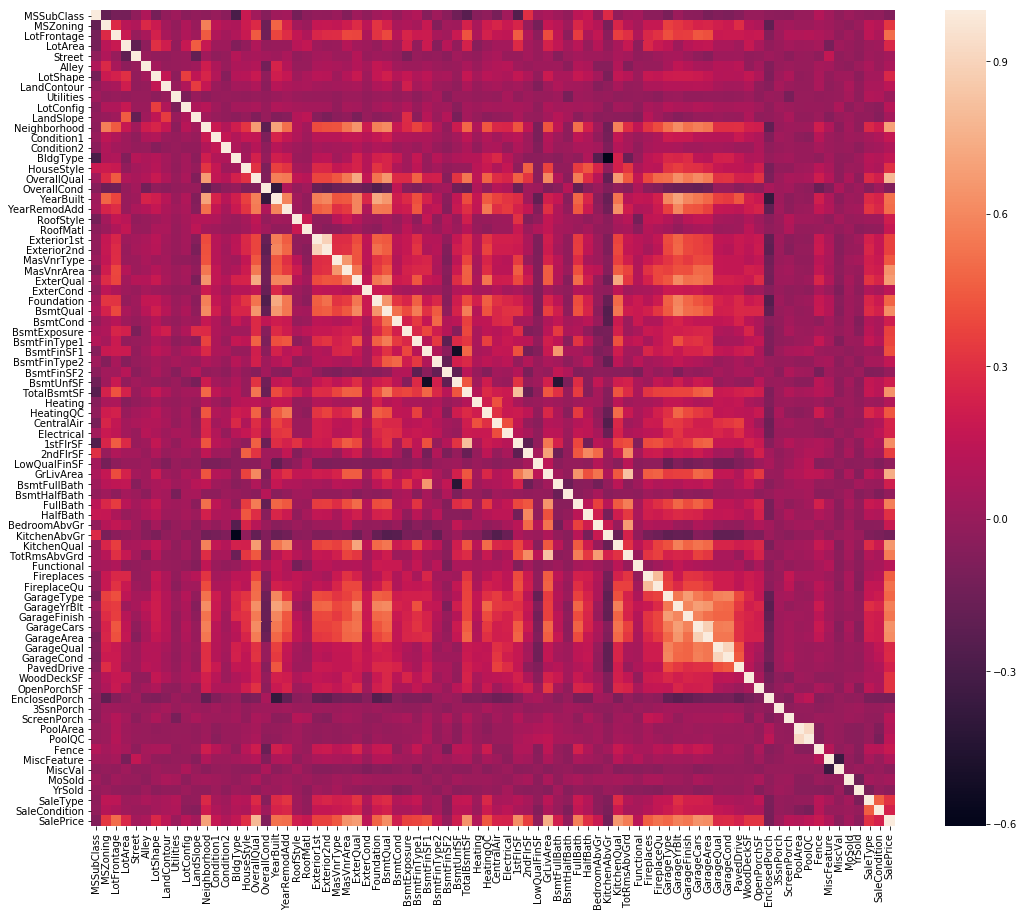

In [133]:
plt.figure(figsize=(18,15))
sns.heatmap(pdAllData.drop(['Id'],axis=1).corr())
plt.show()

In [295]:
def preprocessing(pdAllData_Categ,pdTestData_Categ=[],scaling=True,encoding_technique='labelEncode'):
    #Encoding
    #pdAllData_clean = cleaning(pdAllData_Categ)
    #pdTestData_clean = cleaning(pdTestData_Categ)
    pdAllData,pdTestData = encodeCategoricalFeatures(pdAllData_Categ,pdTestData_Categ,encoding_technique)
    
    X = pdAllData.drop(['Id','SalePrice'],axis=1)
    Y = pdAllData.SalePrice
    kept_columnValues = list(X.columns.values)
    if encoding_technique == 'persoLabelEncodeOrdered':  #Encode the same way as test data
        X_test = pdTestData.drop(['Id'],axis=1)
        allX = pd.concat([X,X_test],axis=0) # To ensure same scaling between test and training
        #Scaling 
        if scaling:
            X_scaled_array = StandardScaler().fit_transform(allX)
            X_scaled = pd.DataFrame(X_scaled_array,columns=kept_columnValues)
        else: X_scaled = allX
            
        return X_scaled.iloc[range(1200)],X_scaled.iloc[range(1200,len(allX))]
    else:
        if scaling:
            X_scaled_array = StandardScaler().fit_transform(X)
            X_scaled = pd.DataFrame(X_scaled_array,columns=kept_columnValues)
        else: X_scaled = X
        return X_scaled,[]

X_scaled,X_scaled_Test = preprocessing(pdAllData_Categ,pdTestData_Categ,encoding_technique='labelEncode')

In [165]:
#Global Varible to do the processing once and for all
X_scaled_labelEncode,_ = preprocessing(pdAllData_Categ,pdTestData_Categ,encoding_technique='labelEncode')
X_scaled_OneHotEncode,_ = preprocessing(pdAllData_Categ,pdTestData_Categ,encoding_technique='oneHotEncode')
X_scaled_labelEncodeOrdered,X_scaled_test = preprocessing(pdAllData_Categ,pdTestData_Categ,encoding_technique='persoLabelEncodeOrdered')

## Outlier Detection

In [135]:
outliers_fraction = 0.05

def findOutliers_IsolationForest(outlierDetectionData, X, Y,outliers_fraction):
    clf = IsolationForest(max_samples=len(outlierDetectionData), contamination=outliers_fraction, random_state=42)
    clf.fit(outlierDetectionData)
    scores_pred = clf.decision_function(outlierDetectionData)
    y_pred = clf.predict(outlierDetectionData)
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
    outliers_index = np.where(y_pred==-1)[0]
    X_inlier, Y_inlier = X.drop(outliers_index,axis=0),Y.drop(outliers_index,axis=0)
    X_outlier, Y_outlier = X.filter(outliers_index,axis=0),Y.filter(outliers_index,axis=0)
    return scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier

In [136]:
def plotOutliers(scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier):
    plt.figure(figsize=(16,10))
    plt.subplot(321)
    scores_pred_sorted = np.sort(scores_pred)
    plt.plot([0,1199],[threshold]*2,'--',c='red')
    plt.plot(scores_pred_sorted),plt.xlabel("sample"),plt.ylabel("score")
    plt.subplot(322)
    plt.hist(scores_pred_sorted, bins='auto'),plt.xlabel("score"),plt.ylabel("nb of samples")
    ax = plt.subplot(3,1,(2,3))
    inlier = np.array([[i,scores_pred[i]] for i,x in enumerate(y_pred) if x==1])
    outlier = np.array([[i,scores_pred[i]] for i,x in enumerate(y_pred) if x==-1])
    plt.xlabel('SalePrice')
    plt.ylabel('Outlier Score')
    plt.scatter(Y_inlier,inlier.T[1],marker="o",c=colors.filter(inlier.T[0]),cmap=cmap,label="Inliers")
    plt.scatter(Y_outlier,outlier.T[1],marker="^",c=colors.filter(outlier.T[0]),cmap=cmap,label="Outliers")
    for i in range(len(Y_outlier)): ax.annotate(Y_outlier.iloc[[i]].keys()[0],(Y_outlier.iloc[[i]].values[0],outlier.T[1][i]))
    plt.plot([0,750000],[threshold]*2,'--',c='red')
    #plt.colorbar()
    plt.legend()
    plt.show()

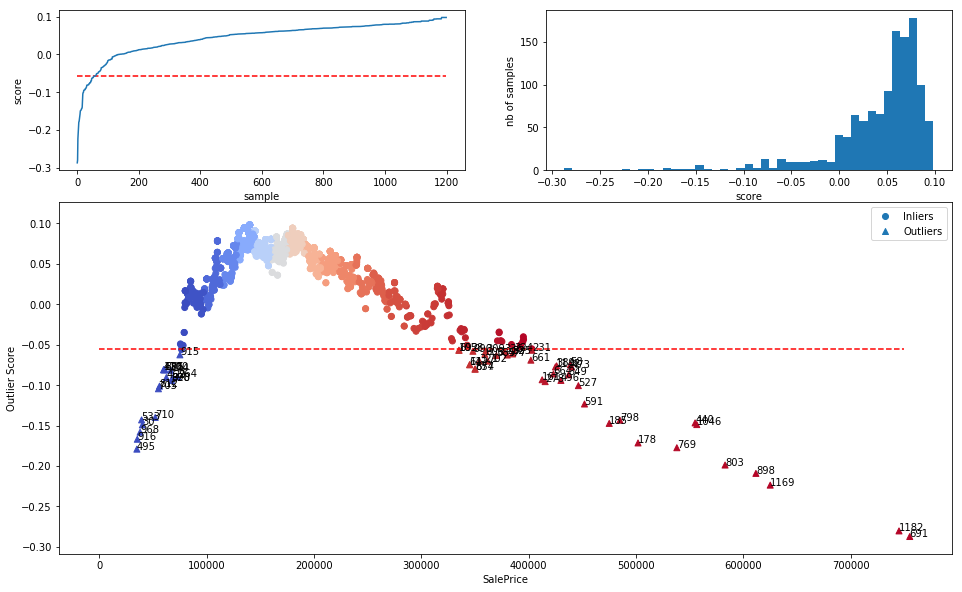

In [137]:
Y = pdAllData_Categ.SalePrice
X = pdAllData_Categ.drop(['Id',"SalePrice"],axis=1)
scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier = findOutliers_IsolationForest(Y.values.reshape(-1,1),X, Y, outliers_fraction)
plotOutliers(scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier)

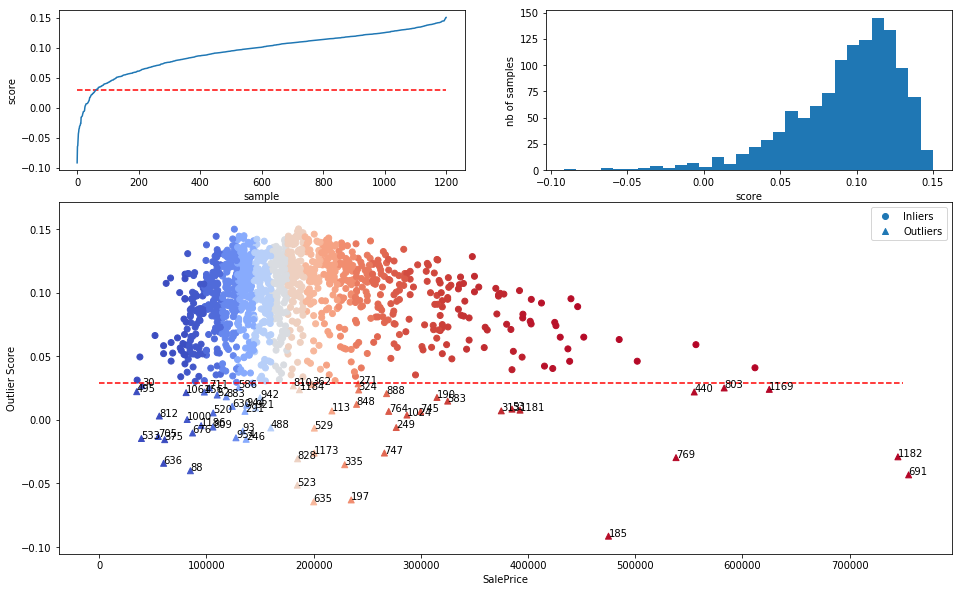

In [138]:
X_num_labelencoded,_ = encodeCategoricalFeatures(pdAllData_Categ,encoding_technique='labelEncode')
scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier = findOutliers_IsolationForest(X_num_labelencoded,X_num_labelencoded, Y, outliers_fraction)
plotOutliers(scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier)

## Feature Selection

<div class='alert alert-warning'>
&emsp;After having encoded the categorical feature the dataset contains 79 or 291 features. In both cases, the problem as it is, is a high dimensionality problem. One can wonder wether all features will actually help our model learn and reach higher precision. The greater the dimension, the more chance the model has to overfit the data. It may give too much importance on a certain feature.<br>
&emsp;To do so, several techniques are used, we chose to stay with a tree like technique to stay on the guideline of this notebook.
</div>

In [139]:
def featureSelection(nbFeature, X,Y,outliers_detection=False,X_outliers=None,tree=True,forest=False):
    """Trims the input data to have nbFeature at the end with a single tree or forest technique
    sort_index,X_trimmed = featureSelection(nbFeature, X,Y,tree=True,forest=False)
    """
    if tree: clf = DecisionTreeRegressor()
    elif forest: clf = RandomForestRegressor(n_estimators=100)
    else: raise Exception("Choose a feature selection process true=True or forest=True")
    clf = clf.fit(X, Y)
    feature_importances = clf.feature_importances_
    sort_index = np.argsort(feature_importances)[::-1]
    kept_columnValues = list(X.columns.values)
    selected_features = np.array(kept_columnValues)[sort_index[:nbFeature]]
    X_trimmed = X.filter(selected_features,axis=1)
    if outliers_detection: X_outliers_trimmed = X_outliers.filter(selected_features,axis=1)
    else: X_outliers_trimmed=None
    return sort_index[::-1],X_trimmed,X_outliers_trimmed,feature_importances,selected_features

In [142]:
nbFeature = X_scaled_labelEncode.shape[1]
sort_index,X_trimmed,_,feature_importances,_ = featureSelection(nbFeature, X_scaled_labelEncode,Y,tree=True,forest=False)
sort_index_forest,X_trimmed,_,feature_importances_forest,_ = featureSelection(nbFeature, X_scaled_labelEncode,Y,tree=False,forest=True)


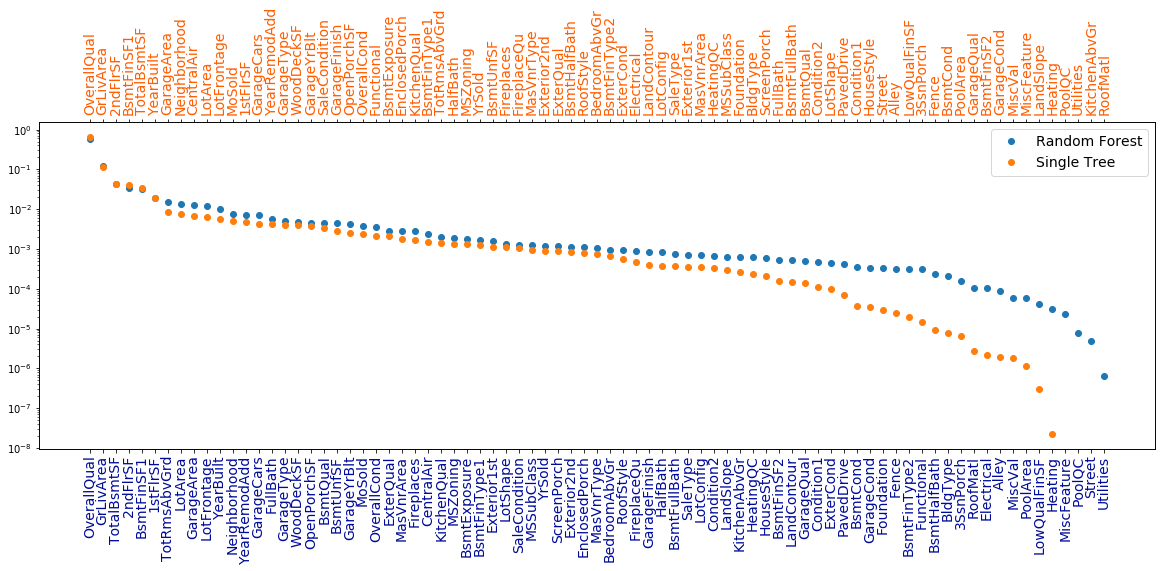

In [143]:
kept_columnValues= list(X.columns.values)
fig, ax =plt.subplots(figsize=(20,6))
ax.semilogy(np.sort(feature_importances_forest)[::-1],'o',label='Random Forest',alpha=1)
locs = ax.set_xticks(np.arange(len(kept_columnValues)))
ax.set_xticklabels(np.array(kept_columnValues)[sort_index_forest][::-1], rotation='vertical',fontsize=14)
[x.set_color('#000c99') for x in ax.get_xticklabels()]

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.arange(len(kept_columnValues)))


ax.semilogy(np.sort(feature_importances)[::-1],'o',label='Single Tree',alpha=1)
ax2.set_xticks(np.arange(len(kept_columnValues)))
ax2.set_xticklabels(np.array(kept_columnValues)[sort_index][::-1], rotation='vertical',fontsize=14)
[x.set_color('#ff5d00') for x in ax2.get_xticklabels()]


pylab.ylabel("Feature Importance")
ax.legend(fontsize=14)
plt.show()

## PCA

In [144]:
def PCA(nbPrincipalComponent,X,test_transform = False,X_test=[]):
    pca = decomposition.PCA(n_components=nbPrincipalComponent)
    pca.fit(X)
    principalComponents = pca.transform(X)
    if test_transform: principalComponents_test = pca.transform(X_test)
    else: principalComponents_test = None
    principalDf = pd.DataFrame(data = principalComponents, columns = ['pc'+str(i+1) for i in range(nbPrincipalComponent)])
    return(principalDf,principalComponents_test)

In [145]:
nbPrincipalComponent = 2
principalDf,_ = PCA(nbPrincipalComponent,X_scaled_labelEncode)


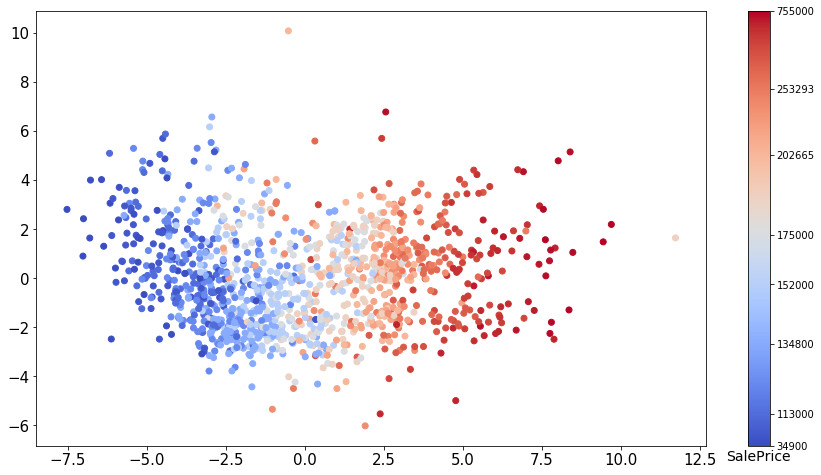

In [491]:
fig = plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(1, 2, width_ratios=[10, 1])
sc = plt.scatter(principalDf.pc1,principalDf.pc2,c=colors,cmap=cmap)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plotColorBarSalePrice(fig,sc)
plt.yticks(fontsize=15)

plt.show()

## Building and Training the statistical model

In [260]:
def getLogRMSE(estimatedPrice,realPrice):
    logRMSE = np.mean( (np.log(estimatedPrice) - np.log(realPrice))**2 )
    #logRMSE = sum( (estimatedPrice - realPrice)**2 )
    return np.sqrt(logRMSE)

def trainModel(model='forest',min_samples_leaf=8,max_depth=6,nb_estimator=20,X=[],Y=[]):
    if model == 'singleTree': regressor = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf,max_depth=depth)
    elif model == 'forest': regressor = RandomForestRegressor(min_samples_leaf=min_samples_leaf,max_depth=depth,n_estimators=nb_estimator,random_state=42)#, max_depth=depth,min_samples_leaf=min_samples_leaf)
    elif model == 'extraTrees': regressor = ExtraTreesClassifier(min_samples_leaf=min_samples_leaf,max_depth=depth,n_estimators=nb_estimator,random_state=42)#, max_depth=depth,min_samples_leaf=min_samples_leaf)
    else: raise Exception("Choose a regression model among 'singleTree', 'forest', 'extreTrees' ")
    regressor.fit(X,Y)
    return regressor
        
    
def regressionTrees(X=X,X_outliers=[],Y_outliers=[],Y=Y,depth=6,min_samples_leaf=8,test_size=0.1,nb_estimator=nb_estimator,model='singleTree'):
    #X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = test_size, random_state = 42)# np.random.randint(0,100))
    nkfold = int(1/test_size)
    foldNb = 0
    kf = KFold(n_splits=nkfold,random_state=42)
    test_errors = []
    training_errors = []
    X= np.array(X)
    Y=np.array(Y)
    X_outliers = np.array(X_outliers)
    Y_outliers = np.array(Y_outliers)
    if(len(X_outliers)>=nkfold): indexSampleOutliers = zip(kf.split(X),kf.split(X_outliers)) #enough outliers to split them into K fold
    else: indexSampleOutliers = zip(kf.split(X),np.zeros((nkfold,2)))    
    for (train_index, test_index), (outliers_train,outliers_index) in indexSampleOutliers:
        #Reset regressor
        

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        if(len(X_outliers)>=nkfold):
            X_outliers_test,X_outliers_train = X_outliers[outliers_index],X_outliers[outliers_train] #get a proportinal number of outliers to calculate error
            Y_outliers_test,Y_outliers_train = Y_outliers[outliers_index],Y_outliers[outliers_train]
            X_train = np.concatenate((X_train,X_outliers_train)) #Add the proportion of outliers in the training set
            y_train = np.concatenate((y_train,Y_outliers_train))
            
        regressor = trainModel(model,min_samples_leaf=min_samples_leaf,max_depth=depth,nb_estimator=nb_estimator,X=X_train,Y=y_train)
        
        y_hat_test = regressor.predict(X_test)
        
        training_estimation = regressor.predict(X_train)
        
        if(len(X_outliers)>=nkfold):
            y_hat_test_outliers = regressor.predict(X_outliers_test)
            y_hat_test = np.concatenate((y_hat_test,y_hat_test_outliers))
            y_test = np.concatenate((y_test,Y_outliers_test))
        
        test_errors.append(getLogRMSE(y_hat_test,y_test))
        training_errors.append(getLogRMSE(training_estimation,y_train))
        
    return np.mean(test_errors),np.mean(training_errors),regressor #test error train error

## Executing the pipeline

In [163]:
def pipeline(pdAllData_Categ,pdTestData_Categ, Y_train,preProcessing=True,encoding_technique='labelEncode', outliers_fraction=0.05, nbFeatures=30, feature_selection_technique='forest', nbPCA=False, model='singleTree',  depth=6, min_samples_leaf=8, test_size=0.1, nb_estimator=20):
    """Full pipeline with a kfold test to do a model selection process"""
    
    if preProcessing: X_scaled,X_scaled_test = preprocessing(pdAllData_Categ,pdTestData_Categ,encoding_technique=encoding_technique)
    else: X_scaled,X_scaled_test = pdAllData_Categ,pdTestData_Categ #Df was preprecessed to avoid costly computations while testing
    
    #Feature Selection
    if nbFeatures>0:
        if feature_selection_technique == 'tree':tree,forest=True,False
        elif feature_selection_technique == 'forest':tree,forest=False,True

        sort_index,X_trimmed,_,_,_ = featureSelection(nbFeatures, X_scaled, Y_train, tree=tree, forest=forest)
    elif nbFeatures<0:X_trimmed = X_scaled
    else: raise Exception('Choose at least 1 feature to be selected or put negative numbers to take all features')
    
    #PCA 
    if nbPCA: X_trimmed_pca,_ = PCA(nbPCA,X_trimmed)
    else: X_trimmed_pca = X_trimmed
    
    #Outliers Detection
    scores_pred, y_pred, threshold, X_inliers, Y_inliers, X_outliers, Y_outliers = findOutliers_IsolationForest(X_trimmed_pca,X_trimmed_pca, Y_train, outliers_fraction)
    
    #Learning and evaluation
    test_error, training_error,regressor = regressionTrees(X=X_inliers,X_outliers=X_outliers,Y_outliers=Y_outliers,Y=Y_inliers,depth=depth,min_samples_leaf=min_samples_leaf,test_size=test_size,nb_estimator=nb_estimator,model=model)
    
    return test_error, training_error,regressor

In [258]:
def predict_save_TestData(regressor,X_test):
    Id = pd.DataFrame(data=np.array([i for i in range(1201,1461)]),columns=['Id'])
    Y_test = pd.DataFrame(regressor.predict(X_test),columns=['SalePrice'])
    #Y_test.Id = Y_test.Id.apply(lambda x:x+1200)
    finalDf = pd.concat([Id,Y_test],axis=1)
    finalDf.to_csv(challenge_data_folder+'/Y_Test.csv',index=False)
def finalPipeline(pdAllData_Categ,pdTestData_Categ,Y_train, preProcessing=True,encoding_technique='labelEncode', outliers_fraction=0.05, nbFeatures=30, feature_selection_technique='forest', nbPCA=False, model='singleTree',  depth=6, min_samples_leaf=8, test_size=0.1, nb_estimator=20,savePrediction=True):
    """ Same As pipeline instead we train on the whole train dataset and predict the test data """
    if preProcessing: X_scaled,X_scaled_test = preprocessing(pdAllData_Categ,pdTestData_Categ,encoding_technique=encoding_technique)
    else: X_scaled,X_scaled_test = pdAllData_Categ,pdTestData_Categ #Df was preprecessed to avoid costly computations while testing
    
    #Feature Selection
    if nbFeatures>0:
        if feature_selection_technique == 'tree':tree,forest=True,False
        elif feature_selection_technique == 'forest':tree,forest=False,True

        sort_index,X_trimmed,_,_,selected_features = featureSelection(nbFeatures, X_scaled, Y_train, tree=tree, forest=forest)
        X_test_trimmed = X_scaled_test.filter(selected_features,axis=1)
        
    elif nbFeatures<0:X_trimmed,X_test_trimmed = X_scaled,X_scaled_test
    else: raise Exception('Choose at least 1 feature to be selected or put negative numbers to take all features')
    
    #PCA 
    
    if nbPCA: X_trimmed_pca,X_test_trimmed_pca = PCA(nbPCA,X_trimmed,test_transform=True,X_test=X_test_trimmed)
    else: X_trimmed_pca,X_test_trimmed_pca = X_trimmed,X_test_trimmed
    
    
    regressor = trainModel(model=model,min_samples_leaf=min_samples_leaf,max_depth=depth,nb_estimator=20,X=X_trimmed_pca,Y=Y_train)
    if savePrediction:   predict_save_TestData(regressor,X_test_trimmed_pca)
    
    train_error = getLogRMSE(regressor.predict(X_trimmed_pca),Y_train)
    print('All done')
    return regressor,train_error

In [238]:
'X_scaled_labelEncode' 'X_scaled_OneHotEncode' 'X_scaled_labelEncodeOrdered,X_scaled_test'
encoding_technique='persoLabelEncodeOrdered'
outliers_fraction=0.05
nbFeatures=50
feature_selection_technique='forest'
model = 'forest'
nbPCA = 10
depth=100
min_samples_leaf=8
test_size=0.25
nb_estimator=20
#X_scaled,X_scaled_test = preprocessing(pdAllData_Categ,pdTestData_Categ,encoding_technique=encoding_technique)

test_error, training_error,_ = pipeline(X_scaled_labelEncode,X_scaled_test,pdAllData_Categ.SalePrice,preProcessing = False, encoding_technique=encoding_technique, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, model=model,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
print('Test Error =',test_error,' Train error = ',training_error)

Test Error = 0.1550626997301096  Train error =  0.11950808583841642


In [237]:
encoding_technique='persoLabelEncodeOrdered'
outliers_fraction=0.05
nbFeatures=50
feature_selection_technique='forest'
model = 'forest'
nbPCA = 10
depth=100
min_samples_leaf=8
test_size=0.25
nb_estimator=20
#X_scaled,X_scaled_test = preprocessing(pdAllData_Categ,pdTestData_Categ,encoding_technique=encoding_technique)
#X_scaled_labelEncodeOrdered,X_scaled_test
regressor,train_error = finalPipeline(X_scaled_labelEncodeOrdered,X_scaled_test,pdAllData_Categ.SalePrice,preProcessing = False, encoding_technique=encoding_technique, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, model=model,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)

print('Train error = ',train_error)

(260, 10)
All done
Train error =  0.11962182060989325


## Optimising the pipeline

In [256]:
outliers_fraction=0.05
nbFeatures=50
feature_selection_technique='forest'
nbPCA = 10
depth=100
min_samples_leaf=8
test_size=0.25
nb_estimator=20

encoding_techniques=['labelEncode','oneHotEncode','persoLabelEncodeOrdered']
preprocessingDicco = {'labelEncode':(X_scaled_labelEncode,[]), 'oneHotEncode':(X_scaled_OneHotEncode,[]),'persoLabelEncodeOrdered':(X_scaled_labelEncodeOrdered,X_scaled_test)}
models = ['singleTree','forest','extraTrees']
outliers_fraction=0.05
nbPCA = False
test_errors = np.zeros((3,3))
training_errors = np.zeros((3,3))
for i,encoding_technique in enumerate(preprocessingDicco):
    (X_scaled,X_test) = preprocessingDicco[encoding_technique]
    print('Evaluating encoding technique:',encoding_technique)
    for j,model in enumerate(models):
        test_error, training_error,_ = pipeline(X_scaled,X_scaled_test,pdAllData_Categ.SalePrice,preProcessing = False, encoding_technique=encoding_technique, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, model=model,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
        test_errors[i,j] = test_error
        training_errors[i,j] = training_error
    print('Done')

Evaluating encoding technique: labelEncode
Done
Evaluating encoding technique: oneHotEncode
Done
Evaluating encoding technique: persoLabelEncodeOrdered
Done


In [257]:
results = pd.DataFrame(data=test_errors,index=encoding_techniques,columns=models)
results

,singleTree,forest,extraTrees
labelEncode,0.184449,0.160388,0.213896
oneHotEncode,0.190243,0.159233,0.219334
persoLabelEncodeOrdered,0.190810,0.154808,0.203750


<div class='alert alert-warning'>
<h2>Comments!
</div>

In [164]:
outliers_fraction=0.05
feature_selection_technique='forest'
model = 'forest'
nbPCA = False
depth=100
min_samples_leaf=8
test_size=0.25
nb_estimator=20
nbFeatures_list = np.arange(2,80,3)
nbFeatures_list_hot = np.arange(2,293,10)
'X_scaled_labelEncode' 'X_scaled_OneHotEncode' 'X_scaled_labelEncodeOrdered,X_scaled_test'
test_errors_labelEncode = []
train_errors_labelEncode = []

test_errors_labelEncodeOrdered = []
train_errors_labelEncodeOrdered = []

test_errors_hotEncode = []
train_errors_hotEncode = []

for nbFeatures in nbFeatures_list:
    print(nbFeatures)
    test_error, training_error,_ = pipeline(X_scaled_labelEncode,X_scaled_test,pdAllData_Categ.SalePrice,preProcessing=False, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, model=model,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
    test_errors_labelEncode.append(test_error)
    train_errors_labelEncode.append(training_error)
    
    test_error, training_error,_ = pipeline(X_scaled_labelEncodeOrdered,X_scaled_test,pdAllData_Categ.SalePrice,preProcessing=False, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, model=model,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
    test_errors_labelEncodeOrdered.append(test_error)
    train_errors_labelEncodeOrdered.append(training_error)
    
for nbFeatures in nbFeatures_list_hot:
    print(nbFeatures)
    test_error, training_error,_ = pipeline(X_scaled_OneHotEncode,X_scaled_test,pdAllData_Categ.SalePrice, preProcessing=False, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, model=model,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
    test_errors_hotEncode.append(test_error)
    train_errors_hotEncode.append(training_error)



2
5
8
11
14
17
20
23
26
29
32
35
38
41
44
47
50
53
56
59
62
65
68
71
74
77
2
12
22
32
42
52
62
72
82
92
102
112
122
132
142
152
162
172
182
192
202
212
222
232
242
252
262
272
282
292


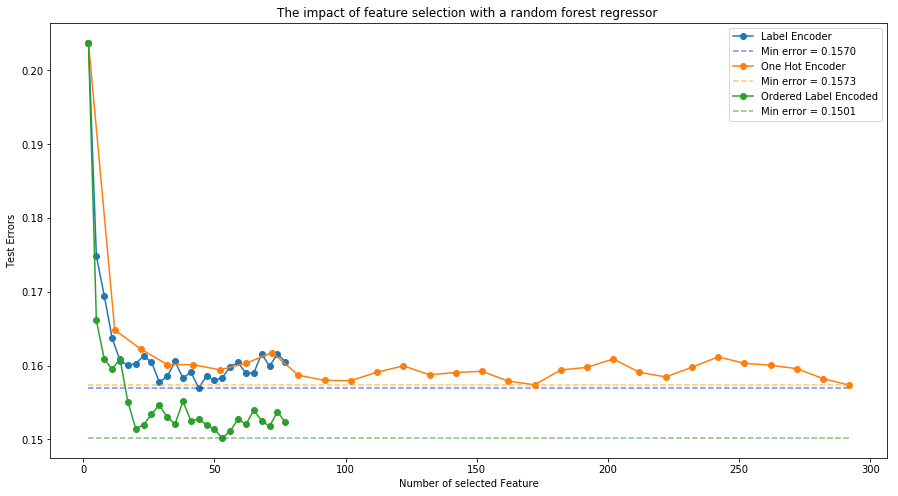

In [166]:
plt.figure(figsize=(15,8))
plt.title('The impact of feature selection with a random forest regressor ')
plt.plot(nbFeatures_list,test_errors_labelEncode,'-o',label='Label Encoder')
plt.plot(nbFeatures_list_hot,[np.min(test_errors_labelEncode)]*len(nbFeatures_list_hot),'--',c='b',alpha=0.5,label='Min error = '+str(np.min(test_errors_labelEncode))[:6])

plt.plot(nbFeatures_list_hot,test_errors_hotEncode,'-o',label='One Hot Encoder')
plt.plot(nbFeatures_list_hot,[np.min(test_errors_hotEncode)]*len(nbFeatures_list_hot),'--',c='orange',alpha=0.6,label='Min error = '+str(np.min(test_errors_hotEncode))[:6])

plt.plot(nbFeatures_list,test_errors_labelEncodeOrdered,'-o',label='Ordered Label Encoded')
plt.plot(nbFeatures_list_hot,[np.min(test_errors_labelEncodeOrdered)]*len(nbFeatures_list_hot),'--',c='g',alpha=0.5,label='Min error = '+str(np.min(test_errors_labelEncodeOrdered))[:6])

plt.ylabel('Test Errors')
plt.xlabel('Number of selected Feature')
plt.legend()
plt.show()

In [167]:
regressor = 'forest'
pca_list = np.arange(1,80,3)
pca_list_hot = np.arange(1,293,10)
nbFeatures = -1
'X_scaled_labelEncode' 'X_scaled_OneHotEncode' 'X_scaled_labelEncodeOrdered,X_scaled_test'
test_errors_labelEncode_pca = []
train_errors_labelEncode_pca = []

test_errors_labelEncodeOrdered_pca = []
train_errors_labelEncodeOrdered_pca = []

test_errors_hotEncode_pca = []
train_errors_hotEncode_pca = []

for nbPCA in pca_list:
    print(nbPCA)
    test_error, training_error,_ = pipeline(X_scaled_labelEncode,X_scaled_test,pdAllData_Categ.SalePrice,preProcessing=False, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, model=model,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
    test_errors_labelEncode_pca.append(test_error)
    train_errors_labelEncode_pca.append(training_error)

    test_error, training_error,_ = pipeline(X_scaled_labelEncodeOrdered,X_scaled_test,pdAllData_Categ.SalePrice,preProcessing=False, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, model=model,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
    test_errors_labelEncodeOrdered_pca.append(test_error)
    train_errors_labelEncodeOrdered_pca.append(training_error)

for nbPCA in pca_list_hot:
    print(nbPCA)
    test_error, training_error,_ = pipeline(X_scaled_OneHotEncode,X_scaled_test,pdAllData_Categ.SalePrice, preProcessing=False, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, model=model,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
    test_errors_hotEncode_pca.append(test_error)
    train_errors_hotEncode_pca.append(training_error)



1
4
7
10
13
16
19
22
25
28
31
34
37
40
43
46
49
52
55
58
61
64
67
70
73
76
79
1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291


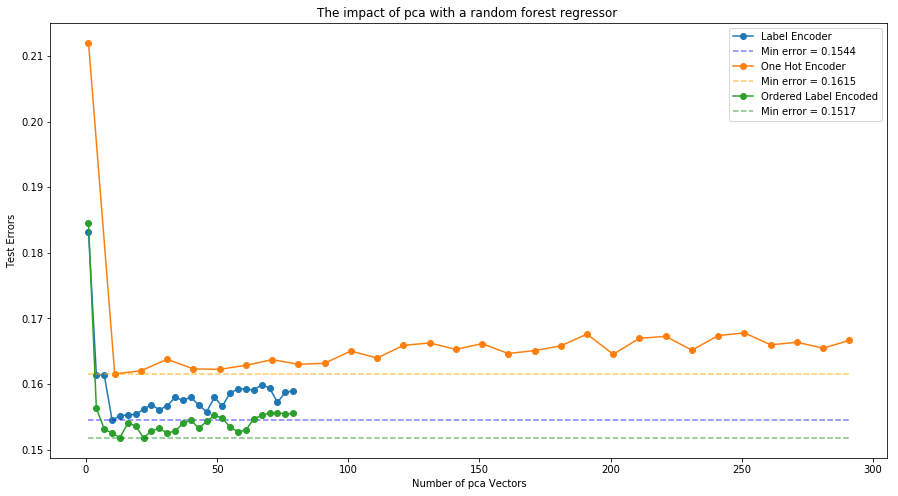

In [168]:
plt.figure(figsize=(15,8))
plt.title('The impact of pca with a random forest regressor ')
#plt.plot(pca_list,test_errors_labelEncode_pca,'-o',label='Label Encoder')
#plt.plot(pca_list_hot,test_errors_hotEncode_pca,'-o',label='One Hot Encoder')
#plt.plot(pca_list_hot,test_errors_labelEncodeOrdered_pca,'-o',label='Ordered Label Encoded')

plt.plot(pca_list,test_errors_labelEncode_pca,'-o',label='Label Encoder')
plt.plot(pca_list_hot,[np.min(test_errors_labelEncode_pca)]*len(pca_list_hot),'--',c='b',alpha=0.5,label='Min error = '+str(np.min(test_errors_labelEncode_pca))[:6])

plt.plot(pca_list_hot,test_errors_hotEncode_pca,'-o',label='One Hot Encoder')
plt.plot(pca_list_hot,[np.min(test_errors_hotEncode_pca)]*len(pca_list_hot),'--',c='orange',alpha=0.6,label='Min error = '+str(np.min(test_errors_hotEncode_pca))[:6])

plt.plot(pca_list,test_errors_labelEncodeOrdered_pca,'-o',label='Ordered Label Encoded')
plt.plot(pca_list_hot,[np.min(test_errors_labelEncodeOrdered_pca)]*len(pca_list_hot),'--',c='g',alpha=0.5,label='Min error = '+str(np.min(test_errors_labelEncodeOrdered_pca))[:6])

plt.ylabel('Test Errors')
plt.xlabel('Number of pca Vectors')
plt.legend()
plt.show()

In [215]:
nbFeatures_list = np.arange(2,80,5)
pca_list = np.arange(2,80,5)
features_grid, pca_grid = np.meshgrid(nbFeatures_list,pca_list)
           

In [216]:
test_error_grid = np.zeros(features_grid.shape)
train_error_grid = np.zeros(features_grid.shape)
for i,nbFeatures in enumerate(nbFeatures_list):            
    for j,nbPCA in enumerate(pca_list):
        if(j<=i): #The PCA is done before the feature selection 
            test_error, training_error,_ = pipeline(X_scaled_labelEncodeOrdered,X_scaled_test,pdAllData_Categ.SalePrice,preProcessing=False, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, model=model,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)
            test_error_grid[i,j] = test_error
            train_error_grid[i,j] = training_error
        else:
            test_error_grid[i,j] = np.nan
            train_error_grid[i,j] = np.nan
    print(i+1,' Feature DONE')

1  Feature DONE
2  Feature DONE
3  Feature DONE
4  Feature DONE
5  Feature DONE
6  Feature DONE
7  Feature DONE
8  Feature DONE
9  Feature DONE
10  Feature DONE
11  Feature DONE
12  Feature DONE
13  Feature DONE
14  Feature DONE
15  Feature DONE
16  Feature DONE


In [217]:
for i,nbFeatures in enumerate(nbFeatures_list):            
    for j,nbPCA in enumerate(pca_list):
        if(i<j): #The PCA is done before the featue selection 
            test_error_grid[i,j] = np.nan
            train_error_grid[i,j] = np.nan

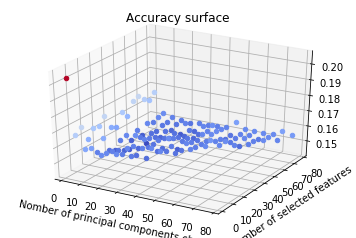

In [226]:
fig = plt.figure()
ax = fig.gca(projection='3d')
max_err = np.nanmax(test_error_grid)
min_err = np.nanmin(test_error_grid)
for i,nbFeatures in enumerate(nbFeatures_list):            
    for j,nbPCA in enumerate(pca_list):
        if j<=i:
            color = (test_error_grid[i,j]-min_err)/(max_err-min_err)
            ax.scatter(features_grid[i,j],pca_grid[i,j],test_error_grid[i,j],c = cm.coolwarm(color))
plt.title('Accuracy surface')
plt.ylabel('Nomber of selected features')
plt.xlabel('Nomber of principal components chosen')
plt.show()


In [ ]:
print(min_err,np.argwhere(test_error_grid,axis=1))

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


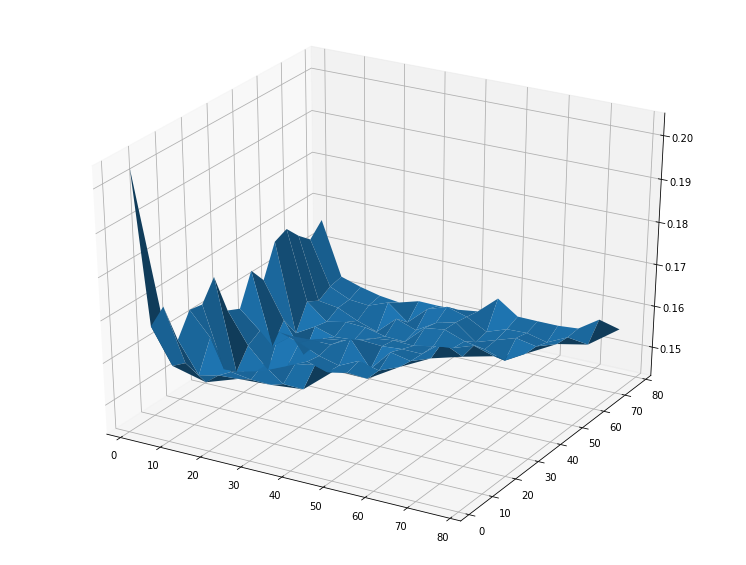

In [222]:
fig = plt.figure(figsize=(13,10))
ax = fig.gca(projection='3d')
ax.plot_surface(features_grid,pca_grid,test_error_grid)
plt.show()

In [193]:
min_err

0.14496842448167774

## Single Tree visualisation

In [310]:
encoding_technique='persoLabelEncodeOrdered'
outliers_fraction=0.05
nbFeatures=-1
feature_selection_technique='forest'
model = 'singleTree'
nbPCA = False
depth = 3
min_samples_leaf = 13
test_size = 0.25
X_singleTree,X_scaled_Test = preprocessing(pdAllData_Categ,pdTestData_Categ,scaling=False,encoding_technique='oneHotEncode')
test_error, training_error,regressor = pipeline(X_singleTree,X_scaled_test,pdAllData_Categ.SalePrice,preProcessing = False, encoding_technique=encoding_technique, outliers_fraction=outliers_fraction, nbFeatures=nbFeatures, feature_selection_technique=feature_selection_technique, nbPCA=nbPCA, model=model,  depth=depth, min_samples_leaf=min_samples_leaf, test_size=test_size, nb_estimator=nb_estimator)

In [312]:
print(test_error)
export_graphviz(regressor, out_file='tree.dot', feature_names=X_singleTree.columns.values,filled=True)

0.24293518493032887


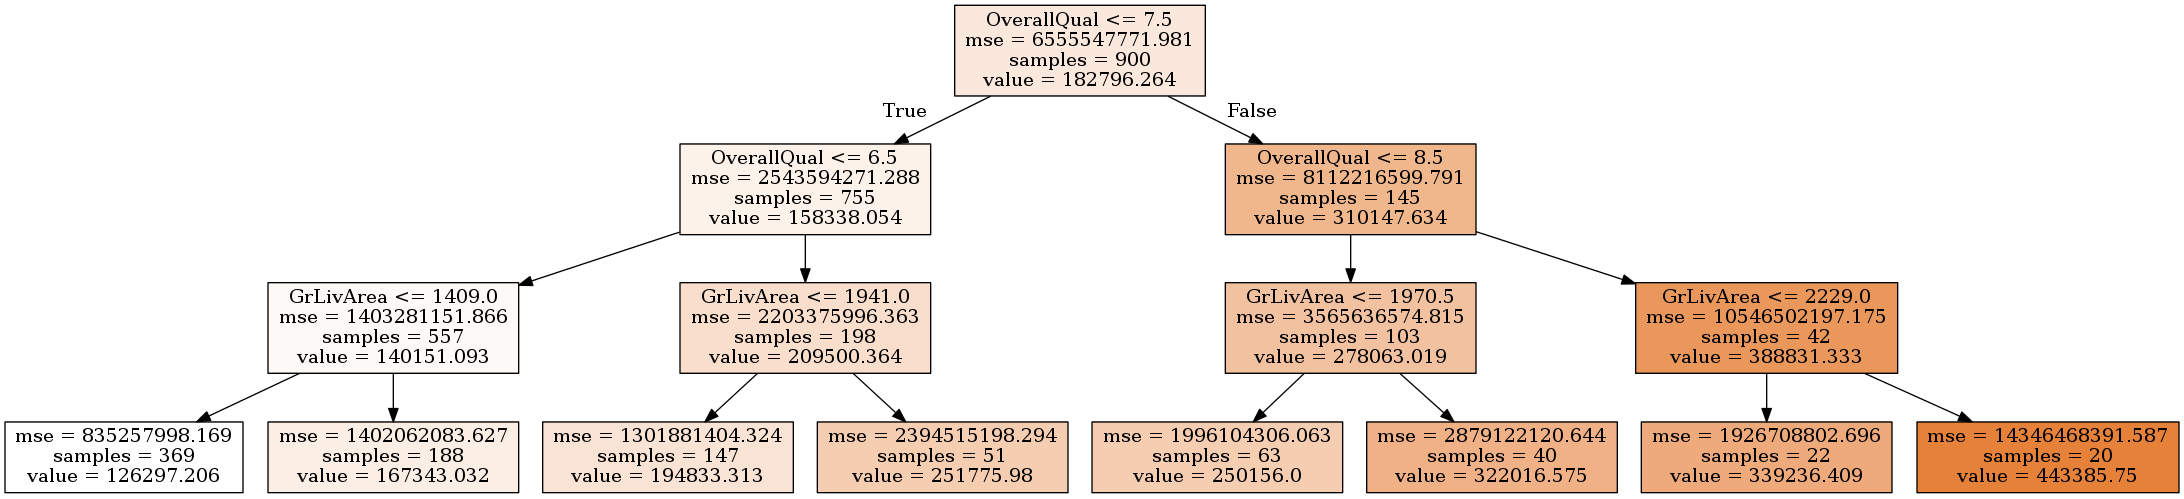

In [314]:
Image(filename='tree.png')

In [446]:
n_nodes = regressor.tree_.node_count
children_left = regressor.tree_.children_left
children_right = regressor.tree_.children_right
feature = regressor.tree_.feature
threshold = regressor.tree_.threshold
value = regressor.tree_.value
value_leaves= value[[3,4,6,7,10,11,13,14]].reshape(-1)

In [487]:
def plotTreeSurface():
    plt.plot([7.5,7.5],[0,5000],'--',c='k',linewidth=5)
    plt.plot([6.5,6.5],[0,5000],'--',c='k',linewidth=3)
    plt.plot([8.5,8.5],[0,5000],'--',c='k',linewidth=3)

    plt.plot([0,6.5],[1409.0,1409.0],'--',c='k',linewidth=1)
    plt.plot([6.5,7.5],[1941.0]*2,'--',c='k',linewidth=1)
    plt.plot([7.5,8.5],[1970.5]*2,'--',c='k',linewidth=1)
    plt.plot([8.5,10.3],[2229]*2,'--',c='k',linewidth=1)
    alpha = 0.3
    plt.fill([8.5,10.3,10.3,8.5],[2229,2229,5000,5000],alpha=alpha, c=cmap(salePriceColor(hist,value_leaves[7])))
    plt.fill([8.5,10.3,10.3,8.5],[0,0,2229,2229],alpha=alpha,c=cmap(salePriceColor(hist,value_leaves[6])))

    plt.fill([7.5,8.5,8.5,7.5],[1970.5,1970.5,5000,5000],alpha=alpha,c=cmap(salePriceColor(hist,value_leaves[5])))
    plt.fill([7.5,8.5,8.5,7.5],[0,0,1970.5,1970.5],alpha=alpha,c=cmap(salePriceColor(hist,value_leaves[4])))

    plt.fill([6.5,7.5,7.5,6.5],[1941.0,1941.0,5000,5000],alpha=alpha,c=cmap(salePriceColor(hist,value_leaves[3])))
    plt.fill([6.5,7.5,7.5,6.5],[0,0,1941.0,1941.0],alpha=alpha,c=cmap(salePriceColor(hist,value_leaves[2])))

    plt.fill([0,6.5,6.5,0],[1409,1409,5000,5000],alpha=alpha,c=cmap(salePriceColor(hist,value_leaves[1])))
    plt.fill([0,6.5,6.5,0],[0,0,1409,1409],alpha=alpha,c=cmap(salePriceColor(hist,value_leaves[0])))

In [489]:
def plotColorBarSalePrice(fig,sc):
    cbar = fig.colorbar(sc, ticks=np.sort(colors)[np.linspace(0,1199,8,dtype=int)])
    cbar.ax.set_yticklabels(np.sort(pdAllData.SalePrice)[np.linspace(0,1199,8,dtype=int)])  # vertically oriented colorbar
    cbar.ax.set_xlabel('SalePrice',fontsize=14)

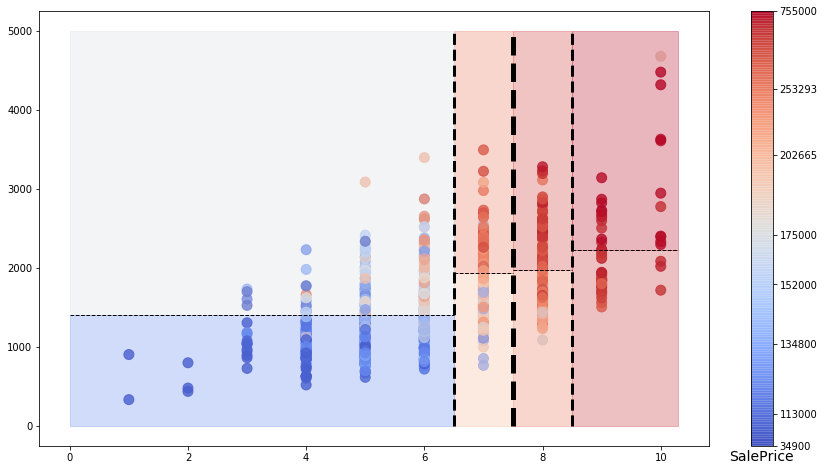

In [490]:
fig = plt.figure(figsize=(15,8))
plotTreeSurface()
cax = plt.scatter(X_singleTree.OverallQual,X_singleTree.GrLivArea,s=100,c=colors,cmap=cmap,alpha=0.8)
plotColorBarSalePrice(fig,cax)
plt.show()

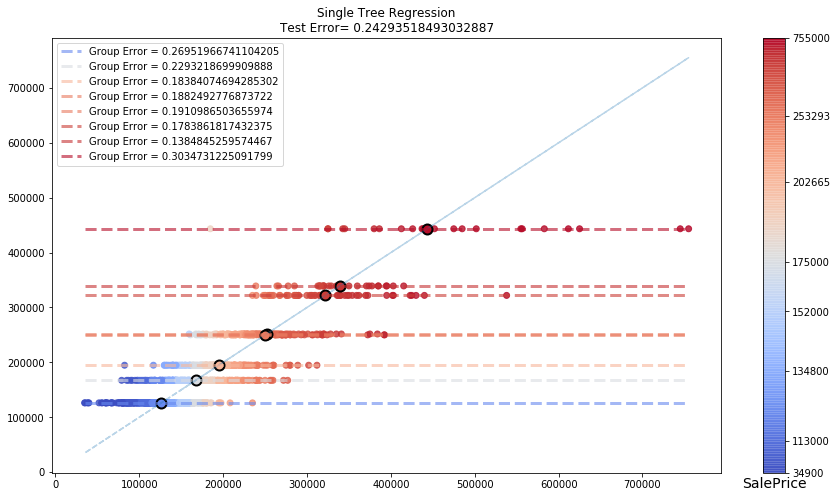

In [521]:
fig = plt.figure(figsize=(15,8))
Y = pdAllData_Categ.SalePrice
Y_hat = pd.Series(data = regressor.predict(X_singleTree))
plt.plot(Y,Y,'--',alpha=0.3,label=''),plt.title("Single Tree Regression"+"\nTest Error= "+str(test_error))
sc = plt.scatter(Y,Y_hat,alpha=0.8,c=colors,cmap=cmap)
groupErrors = []
for val in value_leaves:
    grouped_data = Y_hat.apply(lambda x:x==val)
    Y_hat_grouped = Y_hat[Y_hat.apply(lambda x:x==val)]
    groupError = getLogRMSE(Y_hat_grouped, Y[grouped_data]) 
    plot = plt.plot([34900,755000],[val]*2,'--',linewidth=3,c=cmap(salePriceColor(hist,val)),alpha=0.6,label='Group Error = '+str(groupError))
    groupErrors.append(groupError)
    plotsLines.append(plot)
    plt.scatter(val,val,s=100,edgecolor='k',linewidth=2,c=cmap(salePriceColor(hist,val)))
plotColorBarSalePrice(fig,sc)
plt.legend()
plt.show()

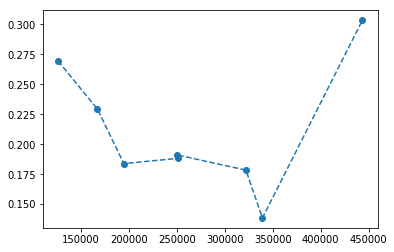

In [523]:
plt.plot(value_leaves,groupErrors,'--o')
plt.show()

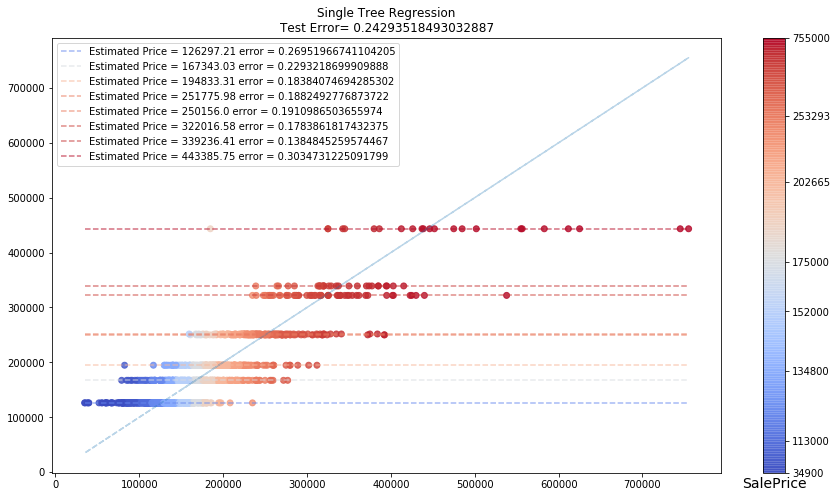